In [10]:
# test: any pom.xml discards?
# 12f23eddde <rzhe@pku.edu.cn> - Apr 28 2021

In [11]:
import sys
import os
import pandas as pd
import numpy as np
import re
import networkx as nx

In [12]:
# read credentials from config
import os
import configparser

config = configparser.ConfigParser()
if (os.path.exists('config.ini')):
    config.read('config.ini')
else:
    raise Exception('config.ini not found')
    
MONGO_URL='mongodb://' + config['MongoDB']['addr']
MONGO_URL

'mongodb://127.0.0.1:27017'

In [13]:
# 并行框架
from tqdm.auto import tqdm
from pathos.pools import ProcessPool
import time

def parallel(func, *args, core_num=8, progress_bar=tqdm, return_df=True):
    pool = ProcessPool(core_num)
    try:
        start = time.time()
        # imap方法
        with progress_bar(total=len(args[0]), desc="计算进度") as t:  # 进度条设置
            if return_df:  # return dataframe
                r = pd.DataFrame()
                for i in pool.imap(func, *args):
                    r = r.append(i, ignore_index=True)
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
                return r
            else:  # return nothing
                for i in pool.imap(func, *args):
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state

In [14]:
CACHE_DIR = "cache/"
if not os.path.exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)
    
import pymongo
# establish db connection
db = pymongo.MongoClient(MONGO_URL).migration_helper

In [15]:
class WOCException(Exception):
    pass

In [16]:
import pandas as pd
df_projects = pd.read_csv('cache/projects.csv', low_memory=False)
df_projects

,_id,hostType,nameWithOwner,description,fork,forkSourceNameWithOwner,createdTimestamp,updatedTimestamp,lastPushedTimestamp,homepageURL,...,contributorsCount,readmeFilename,changeLogFilename,contributingGuidelinesFilename,licenseFilename,codeOfConductFilename,_class,pomFilesCount,pomFileModifyingCommitsCount,commitsCount
0,36668790,GitHub,Snailclimb/JavaGuide,���Java������+��������������� ����������������...,False,NaN,2018-05-07 13:27:00 UTC,2019-12-31 02:06:55 UTC,2019-12-30 01:20:45 UTC,https://javaguide.cn/,...,7,README.md,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,2,3,1524
1,844503,GitHub,iluwatar/java-design-patterns,Design patterns implemented in Java,False,NaN,2014-08-09 16:45:18 UTC,2019-12-28 19:51:58 UTC,2019-12-28 18:46:47 UTC,https://java-design-patterns.com,...,50,README.md,NaN,NaN,LICENSE.md,NaN,edu.pku.migrationhelper.data.LioRepository,149,248,3572
2,167096,GitHub,elastic/elasticsearch,"Open Source, Distributed, RESTful Search Engine",False,NaN,2010-02-08 13:20:56 UTC,2019-12-28 10:52:24 UTC,2019-12-28 08:59:25 UTC,https://www.elastic.co/products/elasticsearch,...,837,README.textile,NaN,CONTRIBUTING.md,LICENSE.txt,NaN,edu.pku.migrationhelper.data.LioRepository,65,540,168154
3,173261,GitHub,spring-projects/spring-boot,Spring Boot,False,NaN,2012-10-19 15:02:57 UTC,2019-12-24 01:03:07 UTC,2019-12-23 16:07:23 UTC,https://spring.io/projects/spring-boot,...,523,README.adoc,NaN,CONTRIBUTING.adoc,LICENSE.txt,CODE_OF_CONDUCT.adoc,edu.pku.migrationhelper.data.LioRepository,588,2148,33165
4,173426,GitHub,square/okhttp,"An HTTP client for Android, Kotlin, and Java.",False,NaN,2012-07-23 13:42:55 UTC,2020-01-01 04:27:06 UTC,2019-12-31 21:41:18 UTC,https://square.github.io/okhttp/,...,200,README.md,CHANGELOG.md,.github/CONTRIBUTING.md,LICENSE.txt,docs/code_of_conduct.md,edu.pku.migrationhelper.data.LioRepository,30,148,7431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19647,40751276,GitHub,lukehutch/serverx,A Vert.x-powered asynchronous multithreaded we...,False,NaN,2019-03-20 06:28:28 UTC,2019-11-28 07:18:34 UTC,2019-03-22 19:06:02 UTC,NaN,...,1,README.md,NaN,NaN,LICENSE,NaN,edu.pku.migrationhelper.data.LioRepository,1,1,49
19648,40989293,GitHub,ThatcherDev/BetterBackdoor,A backdoor with a multitude of features.,False,NaN,2019-07-29 14:45:24 UTC,2019-12-22 15:08:01 UTC,2019-11-10 16:54:02 UTC,NaN,...,1,README.md,NaN,NaN,LICENSE,NaN,edu.pku.migrationhelper.data.LioRepository,1,3,51
19649,41110052,GitHub,PacktPublishing/Spring-5-in-7-Days-v-,NaN,False,NaN,2018-08-14 06:31:38 UTC,2019-12-27 20:38:40 UTC,2018-10-25 10:19:20 UTC,NaN,...,2,README.md,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,26,7,11
19650,41233879,GitHub,zeemood/mail-plus,������������������������������pop���imap���exc...,False,NaN,2019-03-02 07:11:18 UTC,2019-12-31 08:21:32 UTC,2019-05-06 10:14:45 UTC,NaN,...,1,README.MD,NaN,NaN,NaN,NaN,edu.pku.migrationhelper.data.LioRepository,1,1,15


In [17]:
from datautil import select_commits_by_project
import networkx as nx

# build commit graph from project commits (select_commits_by_project)
def get_commit_graph(commits_list: list) -> nx.DiGraph:
    dg = nx.DiGraph()
    for commit in commits_list:
        for parent in commit['parents']:
            dg.add_edge(parent, commit['_id'])
    return dg

commits_list = select_commits_by_project('square/okhttp')
f'{commits_list[0]},{len(commits_list)} nodes, {get_commit_graph(commits_list).number_of_edges()} edges'

"{'_id': '000e62ec37cf9eb630116a62a8cc7c6d0c404543', 'diffs': [{'newBlob': 'da0e827b003b489831301cf87d1327be453ba450', 'oldBlob': '47c185a45209bd6b245e1066f2dc10c6e749baa5', 'filename': 'okhttp-protocols/src/main/java/com/squareup/okhttp/internal/bytes/OkBuffers.java'}, {'newBlob': 'a272e37a4edfef72c28e8c7c14d64c0df83b049c', 'oldBlob': 'cd327db09470d2f3e1d5da94793c5186fc9666f8', 'filename': 'okhttp-protocols/src/test/java/com/squareup/okhttp/internal/bytes/InflaterSourceTest.java'}, {'newBlob': '61d6fd0f68863f02453961c5006569c14d31af25', 'oldBlob': '1b96890cb720f8bc4045bfc9679611f3f8b8474e', 'filename': 'okhttp-protocols/src/test/java/com/squareup/okhttp/internal/bytes/OkBufferTest.java'}], '_class': 'edu.pku.migrationhelper.data.woc.WocCommit', 'timestamp': datetime.datetime(2014, 2, 17, 23, 37, 5, tzinfo=<UTC>), 'parents': ['5be60e4b7003d1cb77b6974d064c7903a610ec6b', '415841c48f1d15018338f0c0438a91232a3b2a22'], 'error': False, 'message': 'Merge pull request #534 from square/jwilson_0

In [18]:
# build commits graph, check if commit changes pom.xml & merge
def analysis_commits(nameWithOwner: str) -> (nx.DiGraph, pd.DataFrame):
    # cache
    cached = os.path.exists(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv")
    
    if not cached:
        # for faster search of properties
        commits_list = select_commits_by_project(nameWithOwner)
        commits_df = pd.DataFrame(commits_list)
        commits_df = commits_df.set_index('_id')
    else:
        commits_df = pd.read_csv(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv", low_memory=False)
        
        # reconvertion to dict may change dtype
        commits_df['diffs'] = commits_df['diffs'].apply(eval)
        commits_df['parents'] = commits_df['parents'].apply(eval)
        
        # # converting to list might be slow
        # commits_list = commits_df.to_dict('records')
        commits_df = commits_df.set_index('_id')

    # build commits graph
    dg = nx.DiGraph()
    for idx, commit in commits_df.iterrows():
#         if type(commit['parents']) is str:
#             commit['parents'] = eval(commit['parents'])
        for parent in commit['parents']:
            dg.add_edge(parent, idx)

    # drop nodes not in woc
    nodes_to_remove = []
    for node in dg.nodes:
        if node not in commits_df.index:
            nodes_to_remove.append(node)
    dg.remove_nodes_from(nodes_to_remove)
    
    if not cached:
        # pom
        for idx, commit in commits_df.iterrows():
            pom_flag=False
            for diff in commit['diffs']:
                if re.match(diff['filename'], r'pom.xml$'):
                    pom_flag = True
                    break
            commits_df.at[idx, 'is_pom'] = pom_flag

        # merge
        for node in dg.nodes:
            # omit parent commits not present in WOC
            if node in commits_df.index:
                commits_df.at[node, 'is_merge'] = bool(dg.in_degree(node) >= 2)
                
        commits_df.to_csv(f"cache/commits/{nameWithOwner.replace('/', '_')}.csv")
            
    return dg, commits_df
    

dg, commits_df = analysis_commits('square/okhttp')
print(f'{dg.number_of_nodes()} nodes, {dg.number_of_edges()} edges')
commits_df

7010 nodes, 9291 edges


,diffs,_class,timestamp,parents,error,message,is_pom,is_merge
_id,,,,,,,,
000e62ec37cf9eb630116a62a8cc7c6d0c404543,[{'newBlob': 'da0e827b003b489831301cf87d1327be...,edu.pku.migrationhelper.data.woc.WocCommit,2014-02-17 23:37:05+00:00,"[5be60e4b7003d1cb77b6974d064c7903a610ec6b, 415...",False,Merge pull request #534 from square/jwilson_02...,False,True
0023907dc8ec02b45f94e7d16f602e1fa75d96de,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-04-12 21:01:35+00:00,"[9f5a96fe7c8aaa6eab764a5bf9d5dbfe09be6030, bbd...",False,Merge bbd184df6be0dae1c7228b836c032b25e4653394...,False,True
0024b66b4ff830338df387c9e08ba5bade88aa1c,[{'newBlob': 'ce089d18646d4c47fb0f00bcd2781736...,edu.pku.migrationhelper.data.woc.WocCommit,2018-06-20 00:48:57+00:00,[7d5793dcacab6d01f6d3b0c1bfab30b4e5f20317],False,Move conscrypt NONE checks internal to Handsha...,False,False
0028e0e75fd6f0474f0f4f3355e11d46e082955e,[{'newBlob': '473d3ce2ce1c64ceb5bb31a3d1b3542a...,edu.pku.migrationhelper.data.woc.WocCommit,2012-12-29 20:46:42+00:00,"[d10c20a7eba3d2182193e3a1a8342549833f927a, e4a...",False,Merge e4a4cbae4f2f850ec43fa15bee70fa1380d9354c...,False,True
00322de556fcf2b82d09fd704b6ba15ea11597ba,[],edu.pku.migrationhelper.data.woc.WocCommit,2016-01-13 22:08:01+00:00,"[8def52425ea514a9ec2d2410e89a17e85643ec04, 87e...",False,Merge pull request #2207 from square/jwilson_0...,False,False
...,...,...,...,...,...,...,...,...
ffbe3ca5009a443ece2802c49bb366eefbac5906,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-02-05 04:47:18+00:00,[5ecd590c8c0cd7833ed378c8702d3a228817b4e8],False,Bump docs to 3.13.0\n,False,False
ffc35dbd02822bf6584c6144266cbbca6b348b17,[{'newBlob': '848822e94567aa48642db288d7d5f122...,edu.pku.migrationhelper.data.woc.WocCommit,2016-01-02 07:31:14+00:00,[ee83d8d26afd92d27fbcd2a328e882f25a5090c6],False,[maven-release-plugin] prepare release parent-...,True,False
ffd9dbec89743c35fc8c6819cf52aec953b45c12,[{'newBlob': '33c7d955fa38369a2ed53f6d3651e275...,edu.pku.migrationhelper.data.woc.WocCommit,2016-07-02 23:56:09+00:00,[e49bf7015757d321ba01f6307f367b57c15766e3],False,Removed ability to change the HPACK decoder he...,False,False


In [19]:
projects_list = df_projects['nameWithOwner'].to_list()

def save_commits_to_file(project: str):
    analysis_commits(project)
    
# parallel(save_commits_to_file, projects_list, return_df=False, core_num=16)

In [10]:
merge_commit_cnt = 0
pom_commit_cnt = 0
projects_exception = []

projects_list = df_projects['nameWithOwner'].to_list()
for project in tqdm(projects_list):
    try:
        commits_df = pd.read_csv(f"cache/commits/{project.replace('/', '_')}.csv", low_memory=False)
        merge_commit_cnt += len(commits_df[commits_df['is_merge'] == True])
        pom_commit_cnt += len(commits_df[commits_df['is_pom'] == True])
    except Exception:
        projects_exception.append(project)
        continue
    
f'merge:{merge_commit_cnt} pom:{pom_commit_cnt}'

  0%|          | 0/19652 [00:00<?, ?it/s]

'merge:2508618 pom:844934'

In [10]:
# remove error projects
for project in projects_exception:
    if os.path.exists(f"cache/commits/{project.replace('/', '_')}.csv"):
        print(f"cache/commits/{project.replace('/', '_')}.csv")
        os.remove(f"cache/commits/{project.replace('/', '_')}.csv")

NameError: name 'projects_exception' is not defined

In [20]:
dg, commits_df = analysis_commits('square/okhttp')
print(f'{dg.number_of_nodes()} nodes, {dg.number_of_edges()} edges')
commits_df

7010 nodes, 9291 edges


,diffs,_class,timestamp,parents,error,message,is_pom,is_merge
_id,,,,,,,,
000e62ec37cf9eb630116a62a8cc7c6d0c404543,[{'newBlob': 'da0e827b003b489831301cf87d1327be...,edu.pku.migrationhelper.data.woc.WocCommit,2014-02-17 23:37:05+00:00,"[5be60e4b7003d1cb77b6974d064c7903a610ec6b, 415...",False,Merge pull request #534 from square/jwilson_02...,False,True
0023907dc8ec02b45f94e7d16f602e1fa75d96de,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-04-12 21:01:35+00:00,"[9f5a96fe7c8aaa6eab764a5bf9d5dbfe09be6030, bbd...",False,Merge bbd184df6be0dae1c7228b836c032b25e4653394...,False,True
0024b66b4ff830338df387c9e08ba5bade88aa1c,[{'newBlob': 'ce089d18646d4c47fb0f00bcd2781736...,edu.pku.migrationhelper.data.woc.WocCommit,2018-06-20 00:48:57+00:00,[7d5793dcacab6d01f6d3b0c1bfab30b4e5f20317],False,Move conscrypt NONE checks internal to Handsha...,False,False
0028e0e75fd6f0474f0f4f3355e11d46e082955e,[{'newBlob': '473d3ce2ce1c64ceb5bb31a3d1b3542a...,edu.pku.migrationhelper.data.woc.WocCommit,2012-12-29 20:46:42+00:00,"[d10c20a7eba3d2182193e3a1a8342549833f927a, e4a...",False,Merge e4a4cbae4f2f850ec43fa15bee70fa1380d9354c...,False,True
00322de556fcf2b82d09fd704b6ba15ea11597ba,[],edu.pku.migrationhelper.data.woc.WocCommit,2016-01-13 22:08:01+00:00,"[8def52425ea514a9ec2d2410e89a17e85643ec04, 87e...",False,Merge pull request #2207 from square/jwilson_0...,False,False
...,...,...,...,...,...,...,...,...
ffbe3ca5009a443ece2802c49bb366eefbac5906,[],edu.pku.migrationhelper.data.woc.WocCommit,2019-02-05 04:47:18+00:00,[5ecd590c8c0cd7833ed378c8702d3a228817b4e8],False,Bump docs to 3.13.0\n,False,False
ffc35dbd02822bf6584c6144266cbbca6b348b17,[{'newBlob': '848822e94567aa48642db288d7d5f122...,edu.pku.migrationhelper.data.woc.WocCommit,2016-01-02 07:31:14+00:00,[ee83d8d26afd92d27fbcd2a328e882f25a5090c6],False,[maven-release-plugin] prepare release parent-...,True,False
ffd9dbec89743c35fc8c6819cf52aec953b45c12,[{'newBlob': '33c7d955fa38369a2ed53f6d3651e275...,edu.pku.migrationhelper.data.woc.WocCommit,2016-07-02 23:56:09+00:00,[e49bf7015757d321ba01f6307f367b57c15766e3],False,Removed ability to change the HPACK decoder he...,False,False


In [21]:
pom_commits_list = list(commits_df[commits_df['is_pom'] == True].index)

no_out_nodes = [node for node, degree in dg.out_degree if degree==0]
len(no_out_nodes), len(pom_commits_list)

(1186, 485)

In [22]:
# return a subgraph containing all pom nodes (nodes with pom.xml change)

def get_pom_subgraph(dg, pom_commits_list):
    # using networkx impl; don't reinvent the wheel
    pom_nodes_distance={}

    # only <5% commits are pom commits, this might be more efficient
    for pom_commit in pom_commits_list:
        p = nx.shortest_path_length(dg, source=pom_commit)
        for source, distance in p.items():
            if not source in pom_nodes_distance.keys():
                pom_nodes_distance[source] = {}
            pom_nodes_distance[source][pom_commit] = distance

    sg = nx.DiGraph()
    sg.add_nodes_from(pom_commits_list)

    for pom_commit in pom_commits_list:
        # find parents for a pom node
        pom_before_commit = pom_nodes_distance[pom_commit]
        pom_before_commit.pop(pom_commit)  # pop the node itself
        pom_before_commit_sorted = sorted(pom_before_commit.items(), key=lambda x:x[1])

        # find pom_node -> pom_commit
        added_nodes = set()
        for pom_node, _ in pom_before_commit_sorted:
            add_this_node = True
            for added_node in added_nodes:
                # pom_node -> added_node; skip adding edge
                if pom_node in pom_nodes_distance[added_node].keys():
                    add_this_node=False
                    break
            if add_this_node:
                # add edge
                sg.add_edge(pom_node, pom_commit)
                added_nodes.add(pom_node)

    # remove isolate nodes in subgraph
    isolate_nodes = list(nx.isolates(sg))
    sg.remove_nodes_from(isolate_nodes)
                
    return sg

sg = get_pom_subgraph(dg, pom_commits_list)
sg.number_of_nodes(), sg.number_of_edges()  

(474, 528)

In [23]:
dg, commits_df = analysis_commits('square/okhttp')
pom_commits_list = list(commits_df[commits_df['is_pom'] == True].index)
sg = get_pom_subgraph(dg, pom_commits_list)
sg.number_of_nodes(), sg.number_of_edges()  

(474, 528)

In [24]:
# commit graph got so many isolates & nodes with in/out degree = 0
isolate_nodes = list(nx.isolates(dg))
no_out_nodes = [node for node, degree in dg.out_degree if degree==0]
no_in_nodes = [node for node, degree in dg.in_degree if degree==0]
len(isolate_nodes), len(no_out_nodes), len(no_in_nodes)

(48, 1186, 171)

In [25]:
# so nodes with in/out degree = 0 in subgraph doesn't seem to indicate any exception here
no_out_nodes = [node for node, degree in sg.out_degree if degree==0]
no_in_nodes = [node for node, degree in sg.in_degree if degree==0]
len(no_out_nodes), len(no_in_nodes), no_in_nodes[0]

(112, 33, '039bcf92dbff48d1162016f8cf4ba08a99071717')

In [26]:
# sg is DAG
list(nx.topological_sort(sg))[:10]

['ffc35dbd02822bf6584c6144266cbbca6b348b17',
 '6d1a0b4f96141e084448619b210fdff2e8821886',
 '2b29196ee2ee0e3cac5cf1fb452d36a2d829a24f',
 '37744378908653ad86c654fe56bfbf3f438da824',
 'faea360ddf7c6a3fc8668bfb3856456712e7f71d',
 'b77e76c7367af5a09097f407c0066a227454dec8',
 '0feedd1e65ecaf0a7de4f7ec2da252e2a26d7de4',
 '9bbdf3a9245e83dfb2a2f20afce7fd1dc41f95fb',
 'e369755806fc676b06e6f056997ece421ddbd163',
 'f171096b1124485c538e0f65059d564ed378ab91']

In [27]:
# randomly choose a commit
list(sg.successors('9bbdf3a9245e83dfb2a2f20afce7fd1dc41f95fb'))

['e369755806fc676b06e6f056997ece421ddbd163']

In [28]:
from dateutil.parser import parse
import pytz

# its successor commited later
commit = '9bbdf3a9245e83dfb2a2f20afce7fd1dc41f95fb'
def get_commit_time(commits_df, commit):
    datestr = commits_df.at[commit,'timestamp']
    datetime = parse(datestr).astimezone(pytz.timezone('UTC'))
    return datetime
get_commit_time(commits_df, commit)

datetime.datetime(2014, 2, 1, 3, 24, 54, tzinfo=<UTC>)

In [29]:
tree_len_cnt = 0
for node in no_in_nodes:
    tree = nx.bfs_tree(sg, node)
    tree_len_cnt += len(tree)
tree_len_cnt/len(no_in_nodes)

20.060606060606062

In [30]:
class PomNotExistException(Exception):
    pass

In [35]:
# How to define 'pom.xml discard'?
# No way to find which commit was merged into master branch:
# -> we define a 'discard' as a time when NO pom.xml on ALL branches of the project

from queue import PriorityQueue

def analysis_pom(nameWithOwner: str):
    df_exceptions = pd.DataFrame()
    
    # ignore exceptions
    try:
        dg, commits_df = analysis_commits(nameWithOwner)
        pom_commits_list = list(commits_df[commits_df['is_pom'] == True].index)
        sg = get_pom_subgraph(dg, pom_commits_list)
        no_out_nodes = [node for node, degree in sg.out_degree if degree==0]
        no_in_nodes = [node for node, degree in sg.in_degree if degree==0]

        for no_in_node in no_in_nodes:  # iterate over nodes with no parent

            pom_refcnt = {}
            # nodes sorted by time
            q = PriorityQueue()
            # to walkaround merging, we use sg's bfs tree
            tree = nx.bfs_tree(sg, no_in_node)
            q.put((get_commit_time(commits_df, no_in_node), no_in_node))

            file_not_in_woc = []

            try:
                while not q.empty():
                    top_time, top = q.get()
                    successors = list(tree.successors(top))

                    # computing refcnt after this node
                    for diff in commits_df.at[top, 'diffs']:
                        if re.match(diff['filename'], r'pom.xml$'):
                            if diff['oldBlob'] == '' and diff['newBlob'] != '':
                                # add
                                if diff['filename'] not in pom_refcnt.keys():
                                    pom_refcnt[diff['filename']] = 0
            #                     print('add', diff['filename'])
                                pom_refcnt[diff['filename']] += 1
                                pass
                            elif diff['oldBlob'] != '' and diff['newBlob'] == '':
                                # previous data not present
                                if diff['filename'] not in pom_refcnt.keys():
                                    raise PomNotExistException(diff['filename'])
                                # rem
                                pom_refcnt[diff['filename']] -= 1
                                pass
                            elif diff['oldBlob'] != '' and diff['newBlob'] != '':
                                # previous data not present
                                if diff['filename'] not in pom_refcnt.keys():
                                    raise PomNotExistException(diff['filename'])
                                # chg
                            else:
                                raise WOCException(f'no blob for commit {top}')

                    # checkpoint
                    no_pom_flag=True
                    for pom, refcnt in pom_refcnt.items():
                        if refcnt > 0:
                            no_pom_flag=False
                    if no_pom_flag:
                        df_exceptions = df_exceptions.append({
                                        'nameWithOwner': nameWithOwner,
                                        'commit': top,
                                        'time': top_time,
                                        'type': 'nopom',
                                        'filename': str(pom_refcnt)
                                    }, ignore_index=True)

                    # update pom refcnt after checkpoint
                    for diff in commits_df.at[top,'diffs']:
                        if re.match(diff['filename'], r'pom.xml$'):
                            if not (diff['oldBlob'] != '' and diff['newBlob'] == ''):
                                # don't do this if pom has been removed
                                pom_refcnt[diff['filename']] += len(successors) - 1

                    # insert childs
                    for child in successors:
                        q.put((get_commit_time(commits_df, child), child))

            except PomNotExistException as e:  
                file_not_in_woc.append(e)
        #         print(f'reworking {e} on commit {no_in_node}')
                df_exceptions = df_exceptions.append({
                                        'nameWithOwner': nameWithOwner,
                                        'commit': no_in_node,
                                        'type': 'pomnotinwoc',
                                        'filename': e
                                    }, ignore_index=True)
                # reinit
                pom_refcnt = {}
                for file in file_not_in_woc:
                    pom_refcnt[file] = 1

                # nodes sorted by time
                q = PriorityQueue()
                # to walkaround merging, we use sg's bfs tree
                tree = nx.bfs_tree(sg, no_in_node)
                q.put((get_commit_time(commits_df, no_in_node), no_in_node))
            
    except Exception:
        return df_exceptions
        
    return df_exceptions

res_df = analysis_pom('elastic/elasticsearch')
res_df[res_df['type']=='nopom']

,commit,filename,nameWithOwner,type,time
91,04876eff6cfe6d71e72f2e2db187b192e5c9271f,{'pom.xml': 0},elastic/elasticsearch,nopom,2013-11-18 21:14:38+00:00


In [36]:
res_df = parallel(analysis_pom, projects_list, core_num=16)
res_df[res_df['type']=='nopom'].to_csv('data/nopom_commits.csv', index=False)
res_df[res_df['type']!='nopom'].to_csv('data/nopom_exceptions.csv', index=False)
res_df[res_df['type']!='nopom']

计算进度:   0%|          | 0/19652 [00:00<?, ?it/s]

,commit,filename,nameWithOwner,type,time
0,0c9136ac01a6d71805b9cc9518a4f614bd525240,pom.xml,iluwatar/java-design-patterns,pomnotinwoc,NaN
1,10bbf988ead88e92ab00223631313ffa58337c53,pom.xml,iluwatar/java-design-patterns,pomnotinwoc,NaN
2,13257b8b33072ae820aadb4fa9731614bfe8b8d7,pom.xml,iluwatar/java-design-patterns,pomnotinwoc,NaN
3,1cad280629d2780ca7866d559e0c155a0e0df5a1,pom.xml,iluwatar/java-design-patterns,pomnotinwoc,NaN
4,1e988c10f9ea5c5f1c4b9c83c0628d0c2fb790ed,pom.xml,iluwatar/java-design-patterns,pomnotinwoc,NaN
...,...,...,...,...,...
81502,ec19d577777cc0652b84b2496cf1c8c6e101e100,pom.xml,88250/latke,pomnotinwoc,NaN
81503,f21daea7644662a246e52fb45fbf2b0d891f73cc,pom.xml,88250/latke,pomnotinwoc,NaN
81504,f31da890e66a5868de1ce62122bfaa361586d50b,pom.xml,88250/latke,pomnotinwoc,NaN
81505,f98fe2d73bd6793df07fa6055052ef7093682f10,pom.xml,88250/latke,pomnotinwoc,NaN


468


{'whiskers': [<matplotlib.lines.Line2D at 0x7f4439a064c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4439a2f1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4439a06bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4439a3fd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4439a3fcd0>],
 'means': []}

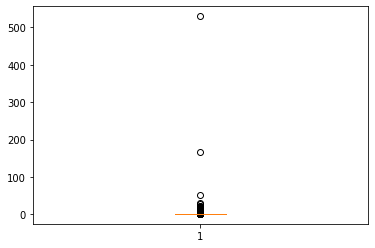

In [51]:
no_pom_projects = res_df[res_df['type']=='nopom'].groupby('nameWithOwner')

no_pom_count = {}
no_pom_count_list = []
for idx, commits in no_pom_projects.groups.items():
    no_pom_count[idx] = len(commits)
    no_pom_count_list.append(len(commits))
    
import matplotlib.pyplot as plt
print(np.sum(np.array(no_pom_count_list) == 1))
plt.boxplot(no_pom_count_list)